IMPORTS

In [1]:
import sys
import os
import torch.cuda
from arango import ArangoClient
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
from DepthAPIUtility import DepthAPIUtility

Check GPU available

In [2]:
if torch.cuda.is_available():
    print("CUDA is available :D")
else:
    print("CUDA isn't available :(")


CUDA is available :D


In [3]:
sys.path.append("/workspaces/NEBULA2")
print(sys.path)
from nebula_api.nebula_enrichment_api import NRE_API
nre = NRE_API()
db = nre.db
api = DepthAPIUtility()
print(nre.db_host)

# from arango import ArangoClient
# client = ArangoClient(hosts='http://ec2-18-158-123-0.eu-central-1.compute.amazonaws.com:8529')
# dbname = 'nebula_development'
# db_manual = client.db(dbname, username='nebula', password='nebula')
# print(db_manual)

['/workspaces/NEBULA2/experts/depth/../common/../..', '/workspaces/NEBULA2/experts/depth', '/opt/conda/lib/python39.zip', '/opt/conda/lib/python3.9', '/opt/conda/lib/python3.9/lib-dynload', '', '/opt/conda/lib/python3.9/site-packages', '/opt/conda/lib/python3.9/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.9/site-packages', '/workspaces/NEBULA2/experts/depth/..', '/workspaces/NEBULA2']
http://ec2-18-158-123-0.eu-central-1.compute.amazonaws.com:8529/


Load Module and Image

In [4]:
# load model
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load transforms to resize and normalize the image for large or small model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [18]:
def get_movie_scene_frames(movie_meta, object_data):
    print(movie_meta)
    mdfs = movie_meta['mdfs']
    # get the bboxes, description for each frame in mdfs per scene
    for scene in mdfs:
        print(scene)

Get movie info

In [21]:
arango_id = "Movies/92354428"
movie_info = api.get_movie_info(arango_id)
action_data = nre.get_all_expert_data("Actions", arango_id)
object_data = nre.get_all_expert_data("Object", arango_id)
# clip_data = nre.get_clip_data(arango_id)
# scenes = api.get_scenes(arango_id)
movie_meta = api.get_movie_meta(arango_id)
get_movie_scene_frames(movie_meta[arango_id], object_data)

{'_key': '92354428', '_id': 'Movies/92354428', '_rev': '_c4AsHdK---', 'description': 'actionclipautoautotrain00716', 'file_name': 'actionclipautoautotrain00716.avi', 'full_path': '/movies/actionclipautoautotrain00716.avi', 'last_frame': 300, 'mdfs': [[2, 103, 205], [209, 219, 229]], 'meta': {'fps': 25, 'height': 576, 'width': 720}, 'movie_id': 'f0a27202207444bd8bfb77708b0db3c5', 'movie_name': 'actionclipautoautotrain00716', 'scene_elements': [[0, 207], [207, 231]], 'scenes': [[0, 231]], 'status': 'updated', 'tags': ['hollywood', 'pegasus', 'visual genome'], 'updates': 2, 'url_path': 'static/datadriven/actionclipautoautotrain00716.avi'}
[2, 103, 205]
[209, 219, 229]


Load Image and apply transforms

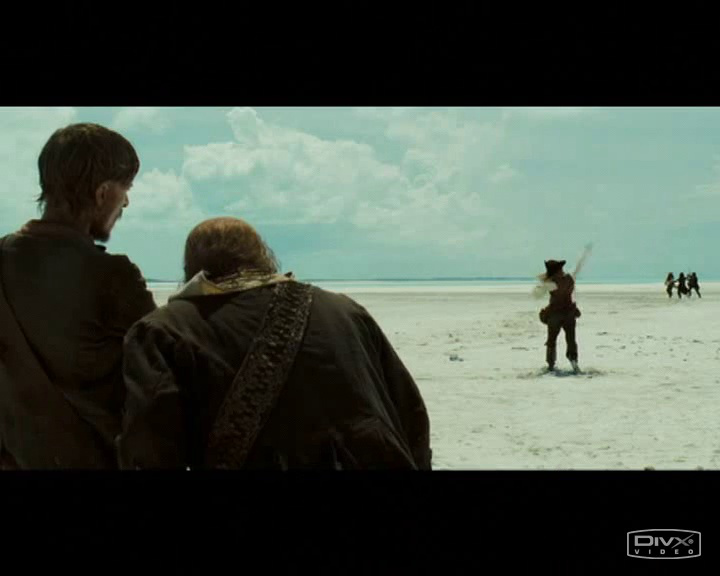

In [7]:
filename = f'/workspaces/data/{arango_id}/frame0210.jpg'
img = Image.open(filename)
img.show()

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)


Predict Depth

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


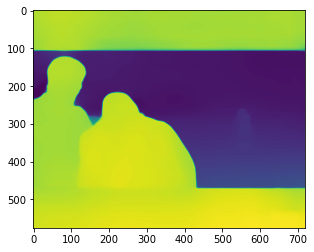

In [10]:
# Predict and resize to original resolution
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

# show results
plt.imshow(output)
plt.show()